# Lab exercise: Real NVP

In [1]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import itertools
import random
import math
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd

%matplotlib inline

In [2]:
# samples1-2 shape must be (n samples, 2)
def plot_samples(samples1, samples2=None):
    fig, ax = plt.subplots()

    ax.scatter(samples1[:,0], samples1[:,1], marker="x", color="blue")
    if samples2 is not None:
        ax.scatter(samples2[:,0], samples2[:,1], marker="x", color="red")

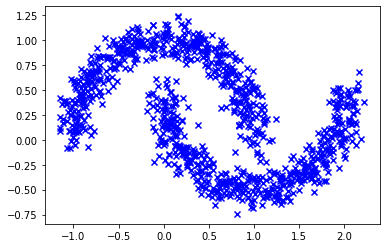

In [3]:
import sklearn.datasets

target_samples, target_classes = sklearn.datasets.make_moons(1000, noise=0.1)
target_samples = torch.from_numpy(target_samples).float()

plot_samples(target_samples)

In [84]:
class RealNVPLayer(nn.Module):
    def __init__(self, size, reverse=False):
        super().__init__()
        
        self.mask = torch.zeros(size, requires_grad=False)
        mid = int(size / 2)
        if reverse:
            self.mask[mid:] = 1.
        else:
            self.mask[:mid] = 1.
        
        ## the two operations
        self.scale = nn.Sequential(
            nn.Linear(size, 10),
            nn.Tanh(),
            nn.Linear(10, size),
        )
        self.transpose = nn.Sequential(
            nn.Linear(size, 10),
            nn.Tanh(),
            nn.Linear(10, size),
        )
        
    # project from the latent space to the observed space,
    # i.e. x = g(z)
    def forward(self, z):
        # you will need this!
        n_mask = 1. - self.mask
        z_masked = z * self.mask

        # s = self.scale(z_masked)*n_mask
        # t = self.transpose(z_masked)*n_mask
        # x = z_masked + n_mask* (z * torch.exp(s) + t)
        s = self.scale(z_masked)
        t = self.transpose(z_masked)
        x = z_masked + ( n_mask * (z * torch.exp(s) + t) )

        return x
    
    # project from the observed space to the latent space,
    # this function also return the log det jacobian of this inv function
    def inv(self, x):
        # you will need this!
        n_mask = 1. - self.mask
        x_masked = x * self.mask
        
        # log_det_jacobian = x.new_zeros(x.shape[0])
        # print(log_det_jacobian)
        s = self.scale(x_masked)
        t = self.transpose(x_masked)
        z = ( n_mask * (x-t)*torch.exp(-s)) + x_masked
        log_det_jacobian = -s.sum(dim=1)
        # print(log_det_jacobian)
        # log_det_jacobian = x.new_zeros(x.shape[0])
        # log_det_jacobian -= s.sum(dim=1)
        # print(log_det_jacobian)

        return z, log_det_jacobian

layer = RealNVPLayer(2, reverse=False)

with torch.no_grad():
    x = torch.rand(1, 2)
    z, _ = layer.inv(x)
    xx = layer(z)

In [85]:
# Test!
layer = RealNVPLayer(2, reverse=False)

with torch.no_grad():
    x = torch.rand(1, 2)
    z, _ = layer.inv(x)
    xx = layer(z)

    print("In the 3 vectors below, the first element must be equal")
    print("This two vectors should be equal:")
    print(x)
    print(xx)
    print("This vector should be different to the two above")
    print(z)
print()

layer = RealNVPLayer(2, reverse=True)

with torch.no_grad():
    x = torch.rand(1, 2)
    z, _ = layer.inv(x)
    xx = layer(z)

    print("In the 3 vectors below, the second element must be equal")
    print("This two vectors should be equal:")
    print(x)
    print(xx)
    print("This vector should be different to the two above")
    print(z)

In the 3 vectors below, the first element must be equal
This two vectors should be equal:
tensor([[0.0813, 0.6206]])
tensor([[0.0813, 0.6206]])
This vector should be different to the two above
tensor([[0.0813, 0.5971]])

In the 3 vectors below, the second element must be equal
This two vectors should be equal:
tensor([[0.3981, 0.3910]])
tensor([[0.3981, 0.3910]])
This vector should be different to the two above
tensor([[0.5981, 0.3910]])


In [86]:
class RealNVP(nn.Module):
    def __init__(self, size, n_layers):
        super().__init__()
        
        self.prior = torch.distributions.normal.Normal(torch.zeros(2), torch.ones(2))
        
        self.layers = nn.ModuleList(
                            RealNVPLayer(size, i % 2 == 0)
                            for i in range(n_layers)
        )
    
    def forward(self, z):
        x = z
        for i in range(len(self.layers)):
            x = self.layers[i](x)
        return x
    
    def inv(self, x):
        log_det_jacobian = 0.
        z = x
        for i in reversed(range(len(self.layers))):
            z, j = self.layers[i].inv(z)
            # remember here, we just have to sum all log det jacobians!
            log_det_jacobian = log_det_jacobian + j
        return z, log_det_jacobian

    
    def sample(self, n_samples):
        z = self.prior.sample((n_samples,))
        x = self(z)
        return x

    def log_prior(self, z):
        x, det = self.inv(z)
        ret = self.prior.log_prob(x).sum(1) + det
        
        return ret

loss 9.982192993164062
loss 8.60582447052002
loss 7.847801208496094
loss 7.424689292907715
loss 7.180319309234619
loss 6.98622465133667
loss 6.78571081161499
loss 6.567846298217773
loss 6.3333611488342285
loss 6.084957599639893
loss 5.825464725494385
loss 5.558241844177246
loss 5.289393424987793
loss 5.033022880554199
loss 4.815653324127197
loss 4.65077543258667
loss 4.499691486358643
loss 4.32443380355835
loss 4.121725559234619
loss 3.9086854457855225
loss 3.703927755355835
loss 3.515209436416626
loss 3.3407680988311768
loss 3.1805546283721924
loss 3.038893461227417
loss 2.9191460609436035
loss 2.816019296646118
loss 2.7210958003997803
loss 2.637404680252075
loss 2.5736019611358643
loss 2.5265893936157227
loss 2.4866750240325928
loss 2.448934316635132
loss 2.4081568717956543
loss 2.3612639904022217
loss 2.3126723766326904
loss 2.274400472640991
loss 2.2511115074157715
loss 2.2299551963806152
loss 2.203063726425171
loss 2.1768596172332764
loss 2.157109022140503
loss 2.140624523162842
l

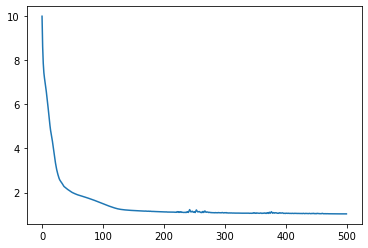

In [87]:
trained_distrib = RealNVP(2, 50)
optimizer = torch.optim.Adam(trained_distrib.parameters(), lr=1e-3)

batch_size = 1000
losses = list()
n_epoch = 500
for _ in range(n_epoch):
    for i in range(0, target_samples.shape[0], batch_size):
        batch = target_samples[i:i+batch_size]
        optimizer.zero_grad()

        loss = -trained_distrib.log_prior(batch).mean()
        print("loss {}".format(loss.item()))
        losses.append(loss.item())

        loss.backward()
        torch.nn.utils.clip_grad_norm_(trained_distrib.parameters(), 5)
        optimizer.step()
    
plt.plot(np.arange(len(losses)), losses)

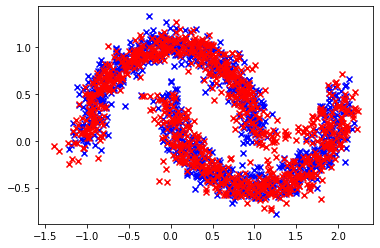

In [92]:
# sample from the model
with torch.no_grad():
    samples = trained_distrib.sample(1000)
    plot_samples(target_samples, samples)

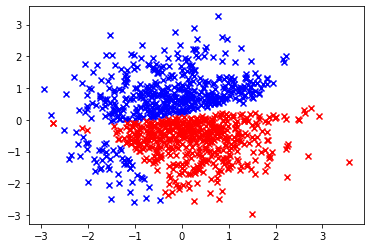

In [57]:
# print the latent space corresponding to each half moon in a different color
with torch.no_grad():
    source_sample1, _ = trained_distrib.inv(target_samples[target_classes == 0])
    source_sample2, _ = trained_distrib.inv(target_samples[target_classes == 1])
    plot_samples(source_sample1, source_sample2)